<a href="https://colab.research.google.com/github/chesnokkk/Classification_with_WB_sweeps/blob/main/Pytorch_classification_with_WB_sweeps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
pip install kaggle
mkdir ~/.kaggle
cp /content/drive/MyDrive/Colab_Notebooks/kaggle.json ~/.kaggle/kaggle.json
chmod 600 ~/.kaggle/kaggle.json
kaggle datasets download -d anshulmehtakaggl/chess-pieces-detection-images-dataset

chess-pieces-detection-images-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
%%bash
mkdir chess_dataset
cp chess-pieces-detection-images-dataset.zip /content/chess_dataset
cd /content/chess_dataset
unzip chess-pieces-detection-images-dataset.zip
rm chess-pieces-detection-images-dataset.zip

Archive:  chess-pieces-detection-images-dataset.zip


mkdir: cannot create directory ‘chess_dataset’: File exists
replace Queen-Resized/00000000_resized.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: new name: replace pieces-detection-images-dataset.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [ ]:
!pip install python-box
!pip install albumentations==0.4.6
!pip install wandb -q
!pip install efficientnet-pytorch

import os
import glob
import wandb
from box import Box
from pathlib import Path

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import cv2
from sklearn.model_selection import train_test_split
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
from torchvision import models
from albumentations import *
from albumentations.pytorch import ToTensorV2

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" 
config = {
    'DATASET_PATH': '/content/chess_dataset',
    'epochs': 10,
    'lr': 1e-4,
    'BATCH_SIZE':32,
    'seed':42,
    'height':224,
    'width':224,
    'device':DEVICE,
}

cfg = Box(config)
print(cfg.device)

cuda


In [ ]:
# seeding in order to reproduce
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.deterministic = True
    print('seeding done!!!')
seeding(cfg.seed)

seeding done!!!


In [ ]:
#Create dataframe
labels = [dir_name for dir_name in os.listdir(cfg.DATASET_PATH)]
label_map = dict(zip(labels, [i for i in range(len(labels))]))
classes = {v: k for k, v in label_map.items()}
path_list = []
label_list = []

for label in labels:
  for image_list in os.walk(os.path.join(cfg.DATASET_PATH, label)):
    for image in image_list[2]:
      if image[-3:] == 'jpg':
          path_list.append(f'{cfg.DATASET_PATH}/{label}/{image}')
          label_list.append(label)

chess_dataframe = pd.DataFrame({'path':path_list, 'label':label_list})


In [ ]:
print(f'Label map:   {label_map}')
print('Examples of dataframe', chess_dataframe.sample(3))

Label map:   {'chess-pieces-detection-images-dataset.zip': 0, 'pieces-detection-images-dataset.zip': 1, 'Queen-Resized': 2, 'knight-resize': 3, 'pawn_resized': 4, 'bishop_resized': 5, 'Rook-resize': 6, '.ipynb_checkpoints': 7}
Examples of dataframe                                                   path         label
608  /content/chess_dataset/Rook-resize/00000022_re...   Rook-resize
302  /content/chess_dataset/pawn_resized/00000143_r...  pawn_resized
621  /content/chess_dataset/Rook-resize/00000004_re...   Rook-resize


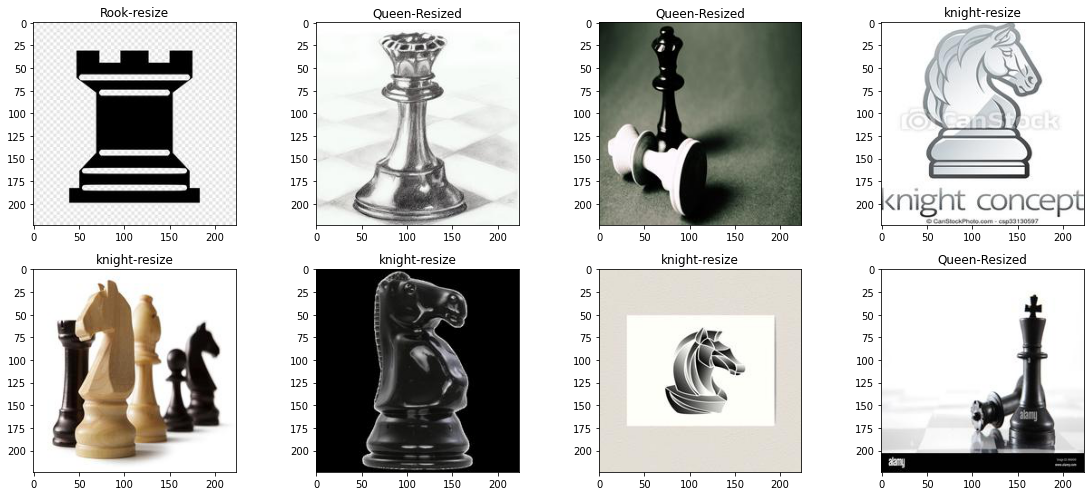

In [ ]:
#show images
fig, axes = plt.subplots(2,4, figsize=(16, 7))
random_idxs = [random.randint(0, len(chess_dataframe['path'])) for _ in axes.flat]

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(chess_dataframe['path'].iloc[random_idxs[i]]))
    ax.set_title(chess_dataframe['label'].iloc[random_idxs[i]])
plt.tight_layout()
plt.show()

In [ ]:
#Data augumentation 
transform = Compose([
        Resize(cfg.height, cfg.width),# VGG-16 Takes 224x224 images as input, so we resize all of them
        HorizontalFlip(p=0.5),
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.9),
        RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
        OneOf([GaussianBlur(),GaussNoise()], p=0.2),
        #Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

target_transform = Compose([
        Resize(cfg.height, cfg.width),       
        #Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]) 

In [ ]:
# Create pytorch dataset
class Chess_dataset(Dataset):
    def __init__(self, paths, labels, transform=None, target_transform=None):
        self.image_paths = paths
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        image = cv2.imread(self.image_paths.iloc[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = label_map[self.labels.iloc[idx]]
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed["image"].float() 
        if self.target_transform:
            transformed = self.target_transform(image=image)
            image = transformed["image"].float() 
        return image, label

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    chess_dataframe['path'],
    chess_dataframe['label'],
    test_size=0.15,
    random_state=cfg.seed
)

In [ ]:
#create datasets
train_dataset = Chess_dataset(
     X_train, y_train, transform=transform
)
val_dataset = Chess_dataset(
     X_val, y_val, target_transform=target_transform
)

In [ ]:
class ClassificationModel(nn.Module):
    def __init__(self, n_features, eff_name, dropout_probability):
        super(ClassificationModel, self).__init__()
        self.model = EfficientNet.from_pretrained(f'efficientnet-{eff_name}')
        self.model.classifier= nn.Sequential(
            nn.Linear(1000, n_features),
            nn.ReLU(inplace = True),
            nn.Dropout(dropout_probability),
            nn.Linear(n_features, len(labels)),
        )
        
    def forward(self, input):
        return self.model(input)


In [ ]:
!wandb login 80656862a97dbf8034a740dd697515543aa07c0a

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#Create our config for seaching optimal hyperparameters
import math
sweep_config = {
                'method': 'random',
                'metric': {'goal': 'minimize', 'name': 'Test Loss'},
                'parameters': {
                    'batch_size': {
                        'distribution': 'q_log_uniform',
                        'max': math.log(80),
                        'min': math.log(16),
                        'q': 1
                    },
                    'epochs': {'value': 20},
                    'eff_name':{'values':['b1','b3']},
                    'dropout_probability':{'values':[0.1, 0.2, 0.05]},
                    'n_features': {'values': [256, 512]},
                    'learning_rate': {'distribution': 'uniform',
                                      'max': 0.001,
                                      'min': 0.00001},
                    'optimizer': {'values': ['adam', 'sgd']},
                    'decay':{'distribution': 'uniform',
                                      'max': 0.0005,
                                      'min': 0.00001},
                }
 }
sweep_id = wandb.sweep(sweep_config, project="test")

Create sweep with ID: 17v90qpm
Sweep URL: https://wandb.ai/roman_siomko/uncategorized/sweeps/17v90qpm


In [ ]:
import time

def train(config=None):
    start_time_sec = time.time()
    print('Train called')
    
    #Start a new run
    with wandb.init(project='test', config=config):
        config = wandb.config

        #Create dataloader
        train_dataloader = DataLoader(
            train_dataset, 
            batch_size=config.batch_size, 
            shuffle=True
            )
        val_dataloader = DataLoader(
            val_dataset, 
            batch_size=config.batch_size, 
            shuffle=True)
        
        #Initialize the model
        torch.cuda.empty_cache()
        model = ClassificationModel(config.n_features, config.eff_name, config.dropout_probability)
        model.to(DEVICE)

        #Set optimizer and loss 
        if config.optimizer == "sgd":
            optimizer = torch.optim.SGD(
                model.parameters(),
                lr=config.learning_rate, 
                momentum=0.9,
                weight_decay=config.decay
                )
        elif config.optimizer == "adam":
            optimizer = torch.optim.Adam(
                model.parameters(), 
                lr=config.learning_rate,
                weight_decay=config.decay)
        loss_fn = nn.CrossEntropyLoss()

        for epoch in range(1, config.epochs+1):

            # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
            model.train()
            train_loss = 0.0
            num_train_correct = 0
            num_train_examples = 0

            for batch in train_dataloader:
                # Compute prediction error
                x = batch[0].to(DEVICE)
                y = batch[1].to(DEVICE)
                yhat = model(x)
                loss = loss_fn(yhat, y)
                
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.data.item() * x.size(0)
                num_train_correct += (torch.max(yhat, 1)[1] == y).sum().item()
                num_train_examples += x.shape[0]

            train_acc = num_train_correct / num_train_examples
            train_loss = train_loss / len(train_dataloader.dataset)

            # --- EVALUATE ON VALIDATION SET -------------------------------------
            model.eval()
            val_loss = 0.0
            num_val_correct = 0
            num_val_examples = 0
            example_images =[]

            for batch in val_dataloader:
                x = batch[0].to(DEVICE)
                y = batch[1].to(DEVICE)
                yhat = model(x)
                loss = loss_fn(yhat, y)
                pred = yhat.max(1, keepdim=True)[1]

                val_loss += loss.data.item() * x.size(0)
                num_val_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
                num_val_examples += y.shape[0]

            val_acc = num_val_correct / num_val_examples
            val_loss = val_loss / len(val_dataloader.dataset)
            
            wandb.log({
                "Test Accuracy": val_acc,
                "Test Loss": val_loss
                })
          
        # END OF TRAINING LOOP
        end_time_sec = time.time()
        total_time_sec = end_time_sec - start_time_sec
        print()
        print('Time total:     %5.2f sec' % (total_time_sec))

In [ ]:
wandb.agent(sweep_id, function=train, count=2)

wandb: Agent Starting Run: r1sdw34k with config:
wandb: 	batch_size: 34
wandb: 	decay: 2.4078502348571184e-05
wandb: 	epochs: 7
wandb: 	learning_rate: 0.007143685087766935
wandb: 	n_features: 256
wandb: 	optimizer: sgd


Train called


wandb: WARNING Ignored wandb.init() arg project when running a sweep



Time total:     44.34 sec


Test Accuracy,▁▄▆▇███
Test Loss,█▄▁▁▁▁▂
Test Accuracy,0.76471
Test Loss,0.90703


wandb: Agent Starting Run: xrxtweha with config:
wandb: 	batch_size: 58
wandb: 	decay: 3.3442412673394794e-05
wandb: 	epochs: 7
wandb: 	learning_rate: 0.0006102117480406403
wandb: 	n_features: 512
wandb: 	optimizer: sgd


Train called


wandb: WARNING Ignored wandb.init() arg project when running a sweep



Time total:     41.91 sec


Test Accuracy,▁▂▆▆▇██
Test Loss,█▇▅▄▃▂▁
Test Accuracy,0.63725
Test Loss,1.24679
